In [1]:
import pandas as pd
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import itertools
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from itertools import product
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [2]:
def reverse(df_log_diff2, df_log_diff_0, df_log_diff_0_index, df_log_0, df_log_0_index):
    r_df_log_diff = df_log_diff2.cumsum()
    r_df_log_diff += df_log_diff_0
    r_df_log_diff = pd.concat([pd.DataFrame({'indeed_job_postings_index_SA_log_diff': [df_log_diff_0]}, index=[df_log_diff_0_index.to_timestamp().to_period('M')]), r_df_log_diff])

    # Step 2: Reverse first differencing
    r_df_log = r_df_log_diff.cumsum()
    r_df_log += df_log_0
    r_df_log = pd.concat([pd.DataFrame({'indeed_job_postings_index_SA_log_diff': [df_log_0]}, index=[df_log_0_index.to_timestamp().to_period('M')]), r_df_log])

    # Step 3: Reverse log transformation
    r_df = np.exp(r_df_log)

    return r_df

/tmp/ipykernel_30369/431629550.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df['indeed_job_postings_index_SA'].resample('M').mean()


ADF Statistic (Log Differenced): -0.6262250365765042
p-value (Log Differenced): 0.8649454604103932
Trying second differencing.
ADF Statistic (Second Differenced): -4.987968522180753
p-value (Second Differenced): 2.344267915492482e-05
Series is now stationary.


/home/laptop24h/Downloads/job_postings_tracker-master/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26682D+00    |proj g|=  2.16278D+01

At iterate    5    f= -1.34355D+00    |proj g|=  1.72514D-01

At iterate   10    f= -1.35405D+00    |proj g|=  3.11600D+00

At iterate   15    f= -1.36857D+00    |proj g|=  2.13289D-01

At iterate   20    f= -1.36870D+00    |proj g|=  3.82855D-02

At iterate   25    f= -1.36879D+00    |proj g|=  1.28413D-01

At iterate   30    f= -1.36893D+00    |proj g|=  1.15398D-02
  ys=-1.882E-10  -gs= 1.683E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

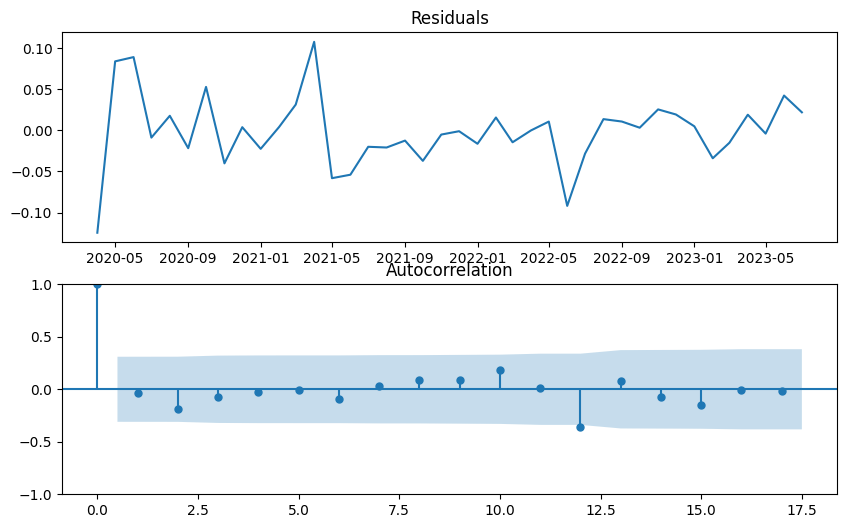

     lb_stat  lb_pvalue
10  4.942674   0.894974


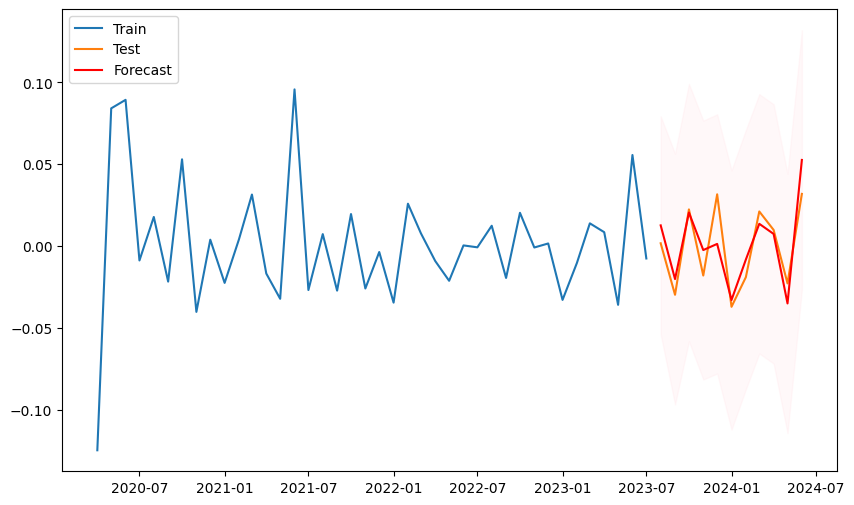

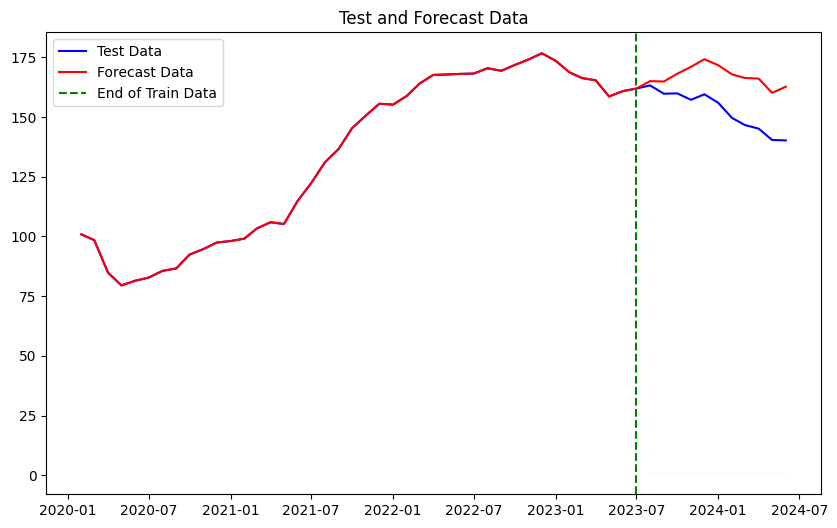

In [3]:
# Load data
df = pd.read_csv('aggregate_job_postings_DE.csv')

# Filter data
df = df[df['variable'] != 'new postings']

# Convert 'date' to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Resample data to monthly frequency and calculate the mean
df = df['indeed_job_postings_index_SA'].resample('M').mean()

# Set the month as index
df.index = df.index.to_period('M')

# Apply log transformation
df_0 = df.iloc[0]
df_0_index = df.index[0]
df_log = np.log(df)

df_log_0 = df_log.iloc[0]
df_log_0_index = df_log.index[0]

# Differencing the log-transformed data to make it stationary
df_log_diff = df_log.diff().dropna()
df_log_diff_0 = df_log_diff.iloc[0]
df_log_diff_0_index = df_log_diff.index[0]

# Convert the differenced Series to DataFrame
df_log_diff = df_log_diff.to_frame(name='indeed_job_postings_index_SA_log_diff')

# Re-check stationarity with ADF test
result_adf_log_diff = adfuller(df_log_diff['indeed_job_postings_index_SA_log_diff'])
print('ADF Statistic (Log Differenced):', result_adf_log_diff[0])
print('p-value (Log Differenced):', result_adf_log_diff[1])

print("Trying second differencing.")

# Further differencing the data to make it stationary
df_log_diff2 = df_log_diff.diff().dropna()

# Re-check stationarity with ADF test for second differencing
result_adf_log_diff2 = adfuller(df_log_diff2['indeed_job_postings_index_SA_log_diff'])
print('ADF Statistic (Second Differenced):', result_adf_log_diff2[0])
print('p-value (Second Differenced):', result_adf_log_diff2[1])

print("Series is now stationary.")
df_final = df_log_diff2

# Convert the stationary series to DataFrame if it's a Series
if isinstance(df_final, pd.Series):
    df_final = df_final.to_frame(name='indeed_job_postings_index_SA_final')

# Split the data into training and testing sets
train_size = int(len(df_final) * 0.8)
train, test = df_final[:train_size], df_final[train_size:]

# Fit SARIMAX model on training data
model = sm.tsa.SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(maxiter=100)

# Print model summary
print(results.summary())

# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_index = test.index

# Get forecasted values
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate error metrics
mae = mean_absolute_error(test, forecast_values)
mse = mean_squared_error(test, forecast_values)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Evaluate the model (residuals, forecast accuracy, visualization)
residuals = results.resid

# Convert the index of residuals to DatetimeIndex for plotting
residuals.index = residuals.index.to_timestamp()
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plot_acf(residuals, ax=plt.gca())
plt.show()

# Perform Ljung-Box test on residuals
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)
# p-value > 0.05 indicates residuals are white noise

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train.index.to_timestamp(), train, label='Train')
plt.plot(test.index.to_timestamp(), test, label='Test')
plt.plot(forecast_index.to_timestamp(), forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index.to_timestamp(), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.1)
plt.legend()
plt.show()





test_combined = pd.concat([train, test])
test_original = reverse(test_combined, df_log_diff_0, df_log_diff_0_index, df_log_0, df_log_0_index)

# Reverse the transformations for forecast data
forecast_combined = pd.concat([train, forecast_values.rename("indeed_job_postings_index_SA_log_diff")])
forecast_original = reverse(forecast_combined, df_log_diff_0, df_log_diff_0_index, df_log_0, df_log_0_index)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_original.index.to_timestamp(), test_original, label='Test Data', color='blue')
plt.plot(forecast_original.index.to_timestamp(), forecast_original, label='Forecast Data', color='red')
plt.fill_between(forecast_index.to_timestamp(), 
                 np.exp(conf_int.iloc[:, 0]), 
                 np.exp(conf_int.iloc[:, 1]), 
                 color='pink', alpha=0.1)
plt.axvline(x=train.index[-1].to_timestamp(), color='green', linestyle='--', label='End of Train Data')
plt.legend()
plt.title('Test and Forecast Data')
plt.show()